# Embeddings

You've learned how to process text by tokenizing it and converting it into tensors, a necessary step for any neural network. However, the integer IDs assigned to words don't inherently capture their meaning or relationships. The number for "cat" is no more related to the number for "dog" than it is to the one for "banana". This is where **word embeddings** come in. Embeddings are dense vector representations that map words into a multi-dimensional space where semantic relationships can be measured mathematically.

In this lab, you'll get hands-on experience with the core concepts behind embeddings and see how they are implemented in PyTorch.

* You will start by loading **pre-trained GloVe embeddings** to explore how they capture semantic similarity and solve analogies like `king - man + woman ≈ queen`.
* Next, you'll **visualize** these high-dimensional vectors in 2D space to see how related concepts form distinct clusters.
* Then, you will **build a simple embedding model from scratch**, defining your own vocabulary and training it to learn word relationships on a specific task.
* Finally, you will investigate the limitations of static embeddings with words that have multiple meanings and see how **contextual models like BERT** provide a more dynamic and powerful solution.

## Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from itertools import permutations

import helper_utils

# Set random seeds for reproducibility
torch.manual_seed(123)
np.random.seed(123)

## Word Embeddings

As you already know, at their core, machine learning models understand numbers, not words. **Word Embeddings** are the solution to this problem for text-based models. They are numerical vector representations of words that are designed to capture their semantic meaning, relationships, and context.

There are two main categories of word embeddings:

* **Static Embeddings**: This is the classic approach where each word in the vocabulary is mapped to a single, fixed vector. Models like **Word2Vec** and **GloVe** use this method. The vector for the word "Apple" is the same, regardless of whether you're talking about the fruit or the technology company.

* **Dynamic (or Contextual) Embeddings**: This is a more advanced approach where the vector for a word changes based on the sentence it's in. Models like **BERT** excel at this, generating different vectors for "Apple" depending on the surrounding context.

You’ll start by looking at a powerful pre-trained static embedding model called **GloVe**.

### GloVe: Static Embeddings

[GloVe](https://nlp.stanford.edu/projects/glove/), which stands for **Global Vectors for Word Representation**, is one of the most popular pre-trained static embedding models. It's an unsupervised learning algorithm that learns word vectors by analyzing a massive corpus of text and computing aggregated global word-word co-occurrence statistics, essentially learning from how frequently words appear near each other.

The creators of GloVe provide several pre-trained models, each trained on different large-scale datasets:

* **glove.6B**: Trained on Wikipedia and Gigaword text, containing 6 billion tokens and a 400,000-word vocabulary.

* **glove.42B** & **glove.840B**: Trained on a massive web dataset (Common Crawl) with 42 billion and 840 billion tokens, respectively. These have much larger vocabularies (1.9M and 2.2M words).

* **glove.twitter.27B**: A model trained specifically on 2 billion tweets with 27 billion tokens.

While the larger models trained on Common Crawl offer vast vocabularies, the **glove.6B** model is an extremely popular starting point for many general-purpose tasks due to its manageable size and powerful performance.

You will be using this **glove.6B** version. Run the next cells to download and load the pre-trained GloVe embeddings.

In [2]:
# Download the data for the GloVe 6B 100d model
helper_utils.download_glove6B()

GloVe data already found in './glove_data'. Skipping download.


In [3]:
# Specify the path to the 100d GloVe file
glove_file = './glove_data/glove.6B.100d.txt'

# Load the pre-trained word vectors from the file
glove_embeddings = helper_utils.load_glove_embeddings(glove_file)

#### Semantic Similarity with GloVe

One of the most powerful features of word embeddings is their ability to capture **semantic similarity**. This means that words with similar meanings will have vector representations that are close to each other in the vector space.

You can measure this closeness using a metric called **cosine similarity**. This metric calculates the cosine of the angle between two vectors. A higher cosine similarity (closer to 1) indicates that the words are more semantically related, while a lower value (closer to 0 or -1) suggests they are not. For example, you would expect the vector for "cat" to have a high cosine similarity with "dog," but a very low similarity with "car".

Beyond simple similarity, these embeddings can also capture more complex relationships and analogies. The most famous example is that the vector relationship between `king` and `man` is similar to that between `queen` and `woman`. You can test this with vector arithmetic: `king - man + woman ≈ queen`.

* Define the `find_closest_words` function, which takes a target vector, the entire embedding dictionary, an optional list of words to exclude, and a `top_n` parameter. Its goal is to return a list of the top `n` most semantically similar words along with their similarity scores.
* To find the closest semantic matches, this function uses a highly efficient vectorized approach to calculate the cosine similarity between the target vector and all other word vectors in a single operation. It sorts the similarity scores to find the top `n` matches and returns them with their corresponding words.

In [4]:
def find_closest_words(embedding, embeddings_dict, exclude_words=[], top_n=5):
    """
    Finds the N most semantically similar words to a given vector and their scores.

    Args:
        embedding: The vector representation of the target word.
        embeddings_dict: A dictionary mapping words to their embedding vectors.
        exclude_words: A list of words to exclude from the search.
        top_n: The number of most similar words to return.

    Returns:
        A list of tuples, where each tuple contains a word and its
        cosine similarity score, sorted in descending order of similarity.
        Returns None if the vocabulary is empty after exclusions.
    """
    # Filter the vocabulary to remove any words in the exclude list.
    filtered_words = [word for word in embeddings_dict.keys() if word not in exclude_words]
    
    # Handle the edge case where the filtered vocabulary is empty.
    if not filtered_words:
        return None
        
    # Create a matrix of all word vectors for efficient computation.
    embedding_matrix = np.array([embeddings_dict[word] for word in filtered_words])
    
    # Reshape the target embedding to a 2D array for the similarity function.
    target_embedding = embedding.reshape(1, -1)
    
    # Calculate cosine similarity between the target and all other words.
    similarity_scores = cosine_similarity(target_embedding, embedding_matrix)
    
    # Get the indices of the top N words with the highest similarity scores.
    closest_word_indices = np.argsort(similarity_scores[0])[::-1][:top_n]
    
    # Create a list of (word, score) tuples for the top N closest words.
    return [(filtered_words[i], similarity_scores[0][i]) for i in closest_word_indices]

* First, check if the words "king," "man," and "woman" exist in the GloVe vocabulary and retrieve their corresponding vectors.

In [5]:
# Ensure the words exist in the glove_embeddings
if all(word in glove_embeddings for word in ['king', 'man', 'woman']):
    king = glove_embeddings['king']
    man = glove_embeddings['man']
    woman = glove_embeddings['woman']

* Now, perform the vector calculation `king - man + woman` to find the resulting embedding for the analogy.

In [6]:
# The resulting vector for the analogy
result_embedding = king - man + woman

* Finally, use the `find_closest_words` function to search the vocabulary for the list of words that are semantically closest to the calculated `result_embedding`.
    * The original words (`king`, `man`, `woman`) are excluded from the search. This prevents the function from simply returning one of the input words, which would not be a meaningful answer to the analogy.

In [7]:
# Set top N words
top_n = 5

# Find the top N closest words, making sure to exclude the inputs
closest_words_with_scores = find_closest_words(
    result_embedding, 
    glove_embeddings, 
    exclude_words=['king', 'man', 'woman'],
    top_n=top_n
)

# Check if any words were returned
if closest_words_with_scores:
    # Unpack the top result (word and score)
    top_word, top_score = closest_words_with_scores[0]

    # Print the top result in the original format with its score
    print(f"king - man + woman ≈ {top_word} (Score: {top_score:.4f})")

    # Print the other 4 results
    if len(closest_words_with_scores) > 1:
        print(f"\n--- Other Top {top_n-1} Results ---")
        # Loop through the rest of the list of tuples
        for word, score in closest_words_with_scores[1:]:
            print(f"{word} (Score: {score:.4f})")

king - man + woman ≈ queen (Score: 0.7834)

--- Other Top 4 Results ---
monarch (Score: 0.6934)
throne (Score: 0.6833)
daughter (Score: 0.6809)
prince (Score: 0.6713)


<br>

This result is a powerful demonstration of how word embeddings capture deep linguistic relationships, allowing you to solve complex analogies with simple vector math. To further see how these vectors group related concepts, you'll now visualize them.

Feel free to experiment with other analogies to see what other relationships the model has learned. For example, you could try:

* `france - paris + tokyo` (to find the country for a given capital)

* `walking - walk + swim` (to find the progressive tense of a verb)

* `uncle - man + woman` (to find the female equivalent)

In [8]:
# Define your analogy

# Your analogy will follow this format:
# word1 - word2 + word3 = ???

# Define your words
word1 = ''
word2 = ''
word3 = ''

# Set how many top results you want to see
top_n = 5

In [9]:
# A list of the words used in the analogy
analogy_words = [word1, word2, word3]

# Check if all the words exist in the embeddings dictionary
if all(word in glove_embeddings for word in analogy_words):
    # Get the embedding vector for each word
    embedding1 = glove_embeddings[word1]
    embedding2 = glove_embeddings[word2]
    embedding3 = glove_embeddings[word3]

    # Perform the vector arithmetic to find the resulting embedding
    result_embedding = embedding1 - embedding2 + embedding3

    # Find the top N closest words to the result, excluding the input words
    closest_words_with_scores = find_closest_words(
        result_embedding, 
        glove_embeddings, 
        exclude_words=analogy_words,
        top_n=top_n
    )

    # Check if the function returned any similar words
    if closest_words_with_scores:
        # Get the top word and its similarity score
        top_word, top_score = closest_words_with_scores[0]

        # Print the analogy and its top result
        print(f"'{word1}' - '{word2}' + '{word3}' ≈ '{top_word}' (Score: {top_score:.4f})")

        # Check if there are other results to display
        if len(closest_words_with_scores) > 1:
            print(f"\n--- Other Top {len(closest_words_with_scores) - 1} Results ---")
            # Loop through the rest of the results and print them
            for word, score in closest_words_with_scores[1:]:
                print(f"{word} (Score: {score:.4f})")
    else:
        # Message if no similar words were found
        print("Could not find any similar words for the given analogy.")

else:
    # Find and report which words are missing from the vocabulary
    missing_words = [word for word in analogy_words if word not in glove_embeddings]
    print(f"Error: The following word(s) were not found in the vocabulary: {missing_words}")
    print("Please try different words.")

Error: The following word(s) were not found in the vocabulary: ['', '', '']
Please try different words.


#### Visualizing GloVe Embeddings

So far, you've confirmed these semantic relationships numerically with vector arithmetic. Another powerful way to understand the structure of these embeddings is to visualize them. However, plotting a vector is not straightforward.

Each word embedding is a vector with a specific number of **dimensions**. For the GloVe model you have loaded, that is 100 dimensions. Each of these dimensions captures a different abstract feature of the word's meaning and its relationships with other words. While having many dimensions allows the model to store rich, nuanced information, it also creates a challenge: it is impossible for us to visualize a 100-dimensional space directly.

To solve this, you can use a powerful dimensionality reduction technique called **Principal Component Analysis (PCA)**. PCA analyzes the data to find the directions of maximum variance and projects the original high dimensional vectors onto a new, lower dimensional space. In simple terms, it helps you squish the 100 dimensions down to just two, an x and y coordinate, while preserving as much of the original semantic structure as possible.

By doing this, you can create a 2D plot to see how GloVe groups related concepts.

* To see this in action, define a `words_to_visualize` list containing the words you'll visualize.
    * Notice that the words in this list can be grouped into clear categories: types of vehicles, types of pets and types of fruits.

In [10]:
# Define the vocabulary of words from different categories to visualize.
words_to_visualize = ['car', 'bike', 'plane',      # Category: Vehicles
                      'cat', 'dog', 'bird',        # Category: Pets
                      'orange', 'apple', 'grape'   # Category: Fruits
]

# A dictionary grouping the same words from `words_to_visualize` by category for easy visualization
visualization_dict = {
    'Vehicle': ['car', 'bike', 'plane'],
    'Pet': ['cat', 'dog', 'bird'],
    'Fruit': ['orange', 'apple', 'grape']
}

* Now, retrieve the GloVe embedding vector for each word in the words_to_visualize list.

In [11]:
# Initialize an empty list to store the vectors.
embedding_vectors_list = []

# Loop through each word in the `words_to_visualize` list.
for word in words_to_visualize:
    # Get the embedding for the word and add it to the list.
    embedding_vectors_list.append(glove_embeddings[word])

# Convert the list of vectors into a NumPy array.
embedding_vectors = np.array(embedding_vectors_list)

* Use PCA to reduce the 100-dimensional embedding vectors down to just two dimensions so they can be plotted.
    * The `n_components=2` parameter specifies that you want to reduce the data to a two-dimensional representation, creating an x and y coordinate for each word.

In [12]:
# Initialize the PCA model to reduce dimensions to 2
reducer = PCA(n_components=2)

# Apply PCA to the embedding vectors to get 2D coordinates
coords_2d = reducer.fit_transform(embedding_vectors)

* Plot the reduced 2D embeddings to see how the words are clustered.

    * **Note**: If you have made any changes to the `words_to_visualize` list, make sure they are appropriately reflected in the `visualization_dict` dictionary as well, otherwise the plot will return an error.

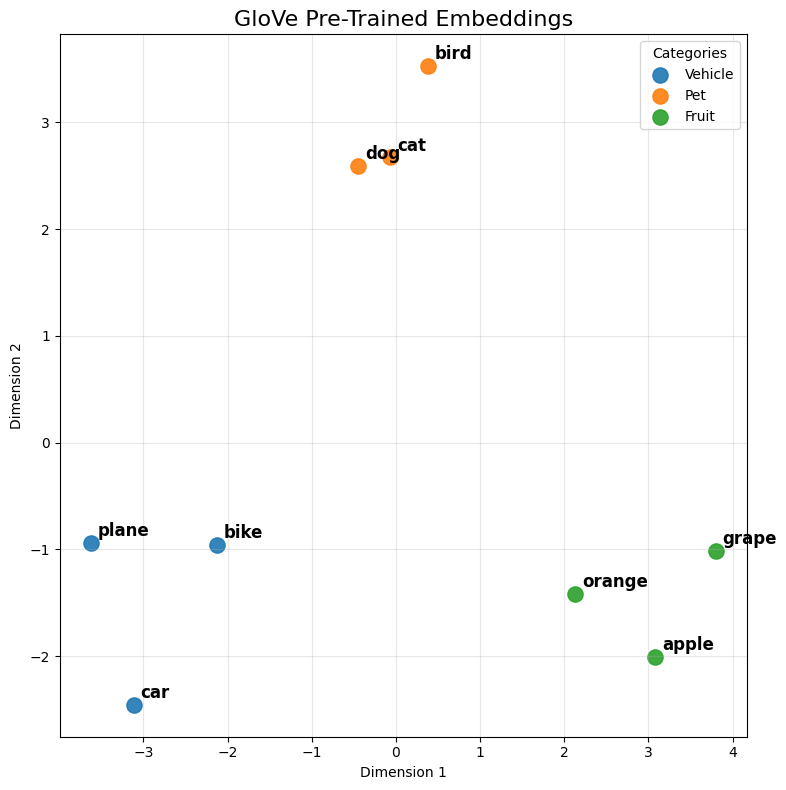

In [13]:
helper_utils.plot_embeddings(coords=coords_2d, 
                             labels=words_to_visualize,
                             label_dict=visualization_dict,
                             title='GloVe Pre-Trained Embeddings'
                            )

The plot above visually confirms that the GloVe model understands word relationships. Even after compressing the vectors from 100 dimensions down to two, the words form distinct clusters based on their semantic category:

* The **vehicles** (`car`, `bike`, `plane`) are grouped together.

* The **pets** (`cat`, `dog`, `bird`) form a second distinct cluster.

* The **fruits** (`orange`, `apple`, `grape`) create a third group.

## Building Your Own Embeddings From Scratch
While pre-trained models like GloVe are powerful, there are many cases where you need to train your own embeddings. This is especially true when working with a specialized vocabulary (e.g., medical or financial terms) that may not be present in the pre-trained models, or when you want to capture semantic relationships specific to your dataset.

In this section, you will learn the fundamental process of training embeddings. You'll start with a small, custom vocabulary and use PyTorch to build a simple model that learns vector representations from scratch.

### Defining the Vocabulary and Parameters

Before creating the model, you need to establish the foundational pieces. This involves defining the specific vocabulary of words the model will learn and setting up key parameters for the embedding layer, such as the size of the vocabulary and the dimension of the embedding vectors.

* Define the `vocabulary` list. This will contain all the words from different semantic categories that your model will learn.

In [14]:
vocabulary = ['car', 'bike', 'plane', 
              'cat', 'dog', 'bird', 
              'orange', 'apple', 'grape']

* Create two essential mappings from your `vocabulary` list: a `word_to_idx` dictionary to convert words into numerical indexes, and an `idx_to_word` dictionary to convert those indexes back into words.
    * This is similar to the `build_vocab` function from the previous lab, but it's more direct because you are starting with a pre-defined list of unique words. Notice that this time the indexing starts from **0**.

In [15]:
# Create word-to-index mapping
# Initialize an empty dictionary for the word-to-index mapping
word_to_idx = {}

# Loop through the vocabulary list with an index
for i, word in enumerate(vocabulary):
    # Assign each word to its corresponding index
    word_to_idx[word] = i
    
# Create index-to-word mapping
# Initialize an empty dictionary for the index-to-word mapping
idx_to_word = {}

# Loop through the items of the newly created word_to_idx dictionary
for word, i in word_to_idx.items():
    # Assign each index to its corresponding word
    idx_to_word[i] = word

* Define the `vocab_size` and `embedding_dim` which are essential parameters for the model.
    * `embedding_dim = 3`: Note that while you are using an embedding dimension of 3 for this simple example, a typical range for larger vocabularies is 100-300.

In [16]:
# Get the total number of unique words in your vocabulary
vocab_size = len(vocabulary)

# Define the size of the embedding vector for each word
embedding_dim = 3

In [17]:
# Print the word-to-index mapping to review it
print("Vocabulary:\tIndex:")
for word, idx in word_to_idx.items():
    print(f"{word}:\t\t{idx}")

# Print the final parameters that will be used for the model
print(f"\nVocabulary size: {vocab_size}")
print(f"Embedding dimension: {embedding_dim}")

Vocabulary:	Index:
car:		0
bike:		1
plane:		2
cat:		3
dog:		4
bird:		5
orange:		6
apple:		7
grape:		8

Vocabulary size: 9
Embedding dimension: 3


### Generating Training Pairs

Now that you've defined your vocabulary, the next step is to create the training data that will teach the model the relationships between these words. The goal is for the model to learn that words within the same category are similar.

You can accomplish this with a simple prediction task. The model learns by being given an input word and trying to predict another word from that same category. This requires structuring your vocabulary into `(input_word, target_word)` pairs to serve as the training examples.

* First, structure your vocabulary into distinct categories using a Python dictionary. This dictionary will map a category name (like 'Vehicles') to a list of words belonging to that category.

In [18]:
# Define the vocabulary, grouped by semantic category.
vocab_categories = {
    'Vehicles': ['car', 'bike', 'plane'],
    'Pets': ['cat', 'dog', 'bird'],
    'Fruits': ['orange', 'apple', 'grape']
}

* To teach the model that words like 'car', 'bike', and 'plane' are related, you need to create training pairs such as `('car', 'bike')`, `('car', 'plane')`, `('bike', 'plane')`, and so on for each category.
* Instead of writing out every combination by hand, you can use Python's `itertools.permutations` function to generate these pairs automatically.

In [19]:
# Initialize an empty list to hold the training pairs.
training_pairs = []

# Iterate through the lists of words in the vocab_categories dictionary.
for category_list in vocab_categories.values():
    # Generate all permutations of 2 words from the list and add them to the training_pairs.
    training_pairs.extend(list(permutations(category_list, 2)))

# Display the total number of pairs and a sample of the generated pairs.
print(f"Generated {len(training_pairs)} training pairs.")
print("Generated pairs:\n")
for pair in training_pairs:
    print(pair)

Generated 18 training pairs.
Generated pairs:

('car', 'bike')
('car', 'plane')
('bike', 'car')
('bike', 'plane')
('plane', 'car')
('plane', 'bike')
('cat', 'dog')
('cat', 'bird')
('dog', 'cat')
('dog', 'bird')
('bird', 'cat')
('bird', 'dog')
('orange', 'apple')
('orange', 'grape')
('apple', 'orange')
('apple', 'grape')
('grape', 'orange')
('grape', 'apple')


### Embedding Model

Now that you have your training data, you need a model that can learn from it. You'll create a simple neural network with two key layers:

* <code>[nn.Embedding](https://docs.pytorch.org/docs/stable/generated/torch.nn.Embedding.html)</code>: It acts as a lookup table where each word's index (like `3` for 'cat') maps to a specific vector. During training, the model uses this vector to make a prediction and then adjusts it to better capture the word's relationships, turning the initially random vector into a meaningful one.

* **nn.Linear**: This is a standard fully connected layer. It will take the word vector from the embedding layer and produce a prediction for the target word.

* Define a `SimpleEmbeddingModel`.
    * The model is initialized with `vocab_size` and `embedding_dim`.
    * It contains an `embedding` **layer** that acts as a lookup table for word vectors.
    * It also contains a `linear` **layer** that produces the final prediction scores.
* Define the `forward` pass for the model.
    * It takes a word's index (`x`) as input.
    * It retrieves the word's vector from the `embedding` layer.
    * It passes that vector to the `linear` layer to get the output.

In [20]:
class SimpleEmbeddingModel(nn.Module):
    """A simple neural network model for learning word embeddings."""
    def __init__(self, vocab_size, embedding_dim):
        """
        Initializes the layers of the model.

        Args:
            vocab_size: The total number of unique words in the vocabulary.
            embedding_dim: The desired dimensionality of the word embeddings.
        """
        # Call the constructor of the parent class (nn.Module).
        super().__init__()
        
        # An embedding layer that maps word indices to dense vectors.
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # A linear layer that projects the embedding vector to the vocabulary size.
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Args:
            x: A tensor of input word indices.

        Returns:
            A tuple containing the output logits from the linear layer and
            the intermediate embedding vectors.
        """
        # The input 'x' is passed through the embedding layer.
        embedded = self.embedding(x)
        # The resulting embedding vector is passed through the linear layer.
        output = self.linear(embedded)
        
        return output, embedded

* Initialize the model.

In [21]:
embedding_model = SimpleEmbeddingModel(vocab_size, embedding_dim)

### Optimizer and Loss Function

* Define the `Adam` optimizer.
* Define Cross Entropy as the loss function.

In [22]:
# Initialize the Adam optimizer
optimizer = torch.optim.Adam(embedding_model.parameters(), lr=0.01)

# Initialize the CrossEntropyLoss function
loss_function = nn.CrossEntropyLoss()

### Training Embeddings with a Simple Model

This training loop follows the same core logic you've seen before: it iterates for multiple **epochs**, performs a **forward pass**, calculates **loss**, and uses a **backward pass** to update the model.

The key difference is how it handles the data. Instead of working with images and labels, this loop is designed for word pairs.
* **Data Iteration**: Rather than using a `DataLoader` that yields batches of `(image, label)`, this loop iterates directly over your simple list of `(word1, word2)` pairs.

* **Text-to-Index Conversion**: The most significant difference is the data preparation step inside the loop. For each pair, the string words (e.g., 'car', 'bike') must be converted into their numerical indices using the `word_to_idx` mapping. This is the essential step for processing text.

* **Input and Target**: In this setup, the index of the first word in the pair (`word1_idx`) is the input to the model. The index of the second word (`word2_idx`) acts as the target label that the loss function uses to measure error.

In [23]:
def training_loop(model, training_pairs, epochs=2000):
    """
    Trains a simple word embedding model.

    Args:
        model: The PyTorch model to be trained.
        training_pairs: A list of tuples, where each tuple is an
                        (input_word, target_word) pair.
        epochs: The total number of training iterations over the dataset.

    Returns:
        A tuple containing the trained model and a list of the average
        loss for each epoch.
    """
    # Set the model to training mode.
    model.train()
    # Initialize a list to store the loss value for each epoch.
    losses = []

    # Loop over the dataset for a specified number of epochs.
    for epoch in range(epochs):
        # Initialize the total loss for the current epoch.
        epoch_loss = 0

        # Loop through each input-target pair in the training data.
        for word1, word2 in training_pairs:
            # Convert the string words into their corresponding numerical indices.
            word1_idx = torch.tensor([word_to_idx[word1]])
            word2_idx = torch.tensor([word_to_idx[word2]])

            # Perform a forward pass to get the model's predictions.
            output, _ = model(word1_idx)
            # Calculate the loss between the predictions and the actual target.
            loss = loss_function(output, word2_idx)

            # Clear any previously calculated gradients before the backward pass.
            optimizer.zero_grad()
            # Compute the gradient of the loss with respect to model parameters.
            loss.backward()
            # Update the model's weights based on the computed gradients.
            optimizer.step()

            # Accumulate the loss for the current epoch.
            epoch_loss += loss.item()

        # Calculate the average loss for the epoch and store it.
        losses.append(epoch_loss / len(training_pairs))

        # Periodically print the training progress.
        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss: {losses[-1]:.4f}")

    # Print the final loss after training is complete.
    print(f"Epoch {epochs}, Loss: {losses[-1]:.4f}")

    return model, losses

* Run the next cell to start training the model.

In [24]:
trained_model, losses = training_loop(embedding_model, training_pairs)

Epoch 0, Loss: 2.5130
Epoch 200, Loss: 0.7247
Epoch 400, Loss: 0.7134
Epoch 600, Loss: 0.7108
Epoch 800, Loss: 0.7098
Epoch 1000, Loss: 0.7092
Epoch 1200, Loss: 0.7089
Epoch 1400, Loss: 0.7087
Epoch 1600, Loss: 0.7085
Epoch 1800, Loss: 0.7084
Epoch 2000, Loss: 0.7083


#### Visualize Training Loss

* Run the next cell to plot the loss values from each epoch.

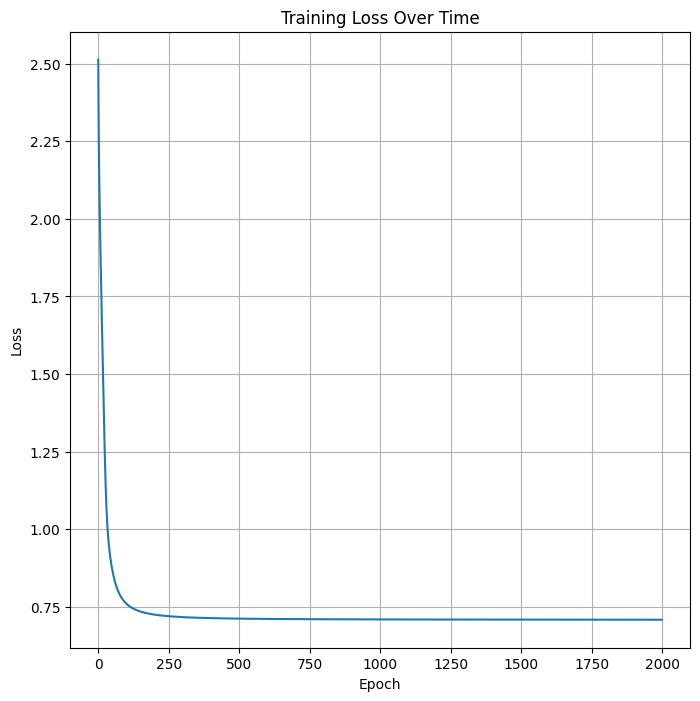

In [25]:
helper_utils.plot_loss(losses)

### Exploring Semantic Similarity

Now that the model is trained, you can check if it has learned meaningful relationships. You'll do this using the same **cosine similarity** metric you explored earlier with the GloVe embeddings.

The goal is to see high similarity scores for words within the same category (e.g., 'car' and 'bike') and low scores for words in different categories (e.g., 'car' and 'cat'). This will confirm that the training was successful.

* Define the `cosine_similarity_words` function.
    * The function will take two words as input and return their similarity score based on the learned embeddings.

In [26]:
def cosine_similarity_words(word1, word2, word_to_idx, embeddings_matrix):
    """
    Calculates the cosine similarity between two words.

    Args:
        word1 (str): The first word to compare.
        word2 (str): The second word to compare.
        word_to_idx (dict): A mapping of words to their indices.
        embeddings_matrix (np.ndarray): The matrix containing all word vectors.
    """
    idx1 = word_to_idx[word1]
    idx2 = word_to_idx[word2]

    emb1 = embeddings_matrix[idx1]
    emb2 = embeddings_matrix[idx2]

    similarity = cosine_similarity([emb1], [emb2])[0][0]

    return similarity

* Pull all the final word vectors from the `trained_model`. The most efficient way is to grab the entire matrix of embeddings at once.

    * `trained_model.embedding.weight`: Directly accesses the final, learned word vectors from the embedding layer's weight matrix.
    * `.detach().numpy()`: Converts the vector matrix from a PyTorch tensor into a NumPy array, making it easier to work with.

In [27]:
# Set the model to evaluation mode.
trained_model.eval()

# Extract the embedding matrix.
all_embeddings = trained_model.embedding.weight.detach().numpy()

* Define test pairs.

In [28]:
similarity_tests = [
    ("car","car"),
    ("car","bike"),
    ("car","plane"),

    ("car","cat"),
    ("car","dog"),
    ("car","bird"),

    ("car","orange"),
    ("car","apple"),
    ("car","grape"),

]

* Finally, loop through the test pairs, calculate the similarity score for each one, and print the results.

In [29]:
print("Semantic Similarity (Cosine Similarity):")
print("="*40)

# Loop through each pair of words in the test list.
for word1, word2 in similarity_tests:
    # Calculate the similarity score for the current pair
    similarity = cosine_similarity_words(word1, word2, word_to_idx, all_embeddings)
    
    # Print the word pair and their calculated similarity
    print(f"{word1} <-> {word2}:\t {similarity:.4f}")

Semantic Similarity (Cosine Similarity):
car <-> car:	 1.0000
car <-> bike:	 0.4451
car <-> plane:	 0.5089
car <-> cat:	 -0.4982
car <-> dog:	 -0.0785
car <-> bird:	 -0.7998
car <-> orange:	 -0.5982
car <-> apple:	 -0.3216
car <-> grape:	 0.1976


* To get a more comprehensive view than just testing a few pairs, calculate the similarity score between every possible combination of words in your vocabulary.

In [30]:
# Initialize an empty square matrix with zeros to hold the similarity scores.
similarity_matrix = np.zeros((vocab_size, vocab_size))

# Iterate through each row of the matrix (representing the first word).
for i in range(vocab_size):
    # Iterate through each column (representing the second word).
    for j in range(vocab_size):
        # For any word compared with itself, the similarity is a perfect 1.0.
        if i == j:
            similarity_matrix[i, j] = 1.0
        # For pairs of different words:
        else:
            # Get the string representation of each word from their indices.
            word1 = idx_to_word[i]
            word2 = idx_to_word[j]
            # Calculate the similarity and place it in the correct cell of the matrix.
            similarity_matrix[i, j] = cosine_similarity_words(word1, word2, word_to_idx, all_embeddings)

* Run the next cell to plot the `similarity_matrix`.

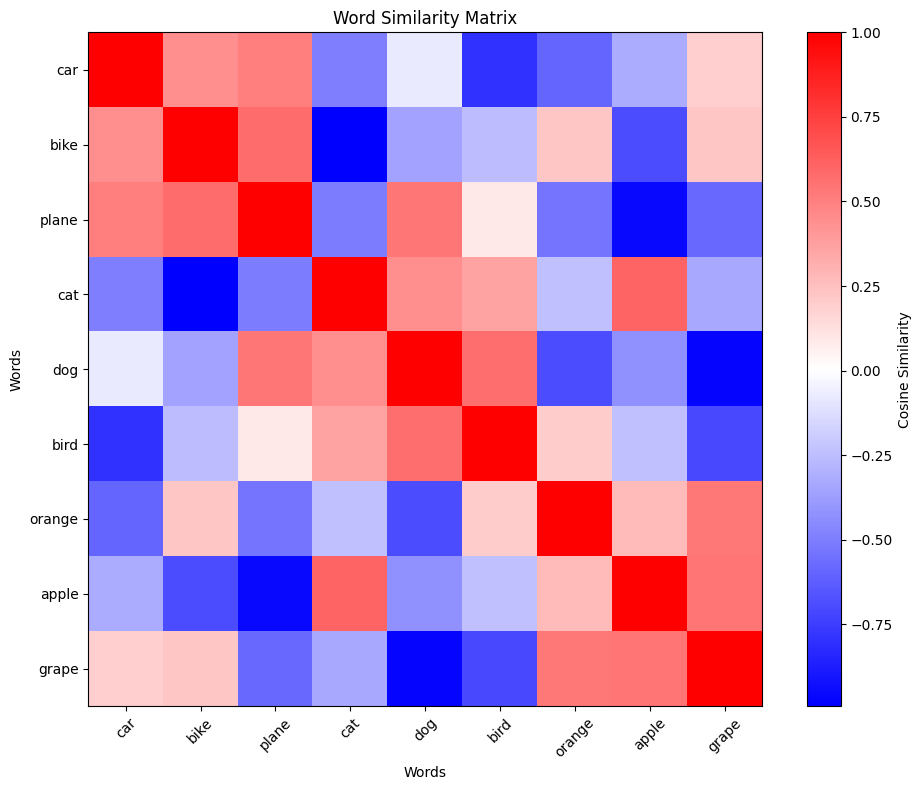

In [31]:
helper_utils.plot_similarity_matrix(similarity_matrix, vocabulary)

The resulting matrix clearly shows that the `Vehicle` words have high similarity between them, but low similarity with the `Pet` and `Fruit` words, and viceversa.

## Visualizing Your Word Embeddings

Now that your basic model is trained, time to see how well it captured the semantic meaning of your small vocabulary. You can then compare your results to the clusters you saw earlier from the pre-trained GloVe model.

* First, use PCA again to reduce your 3-dimensional vectors to 2-dimensional. 

In [32]:
# Reduce dimensionality
reducer = PCA(n_components=2)
coords = reducer.fit_transform(all_embeddings)

* Run the next cell to plot your trained word embeddings.

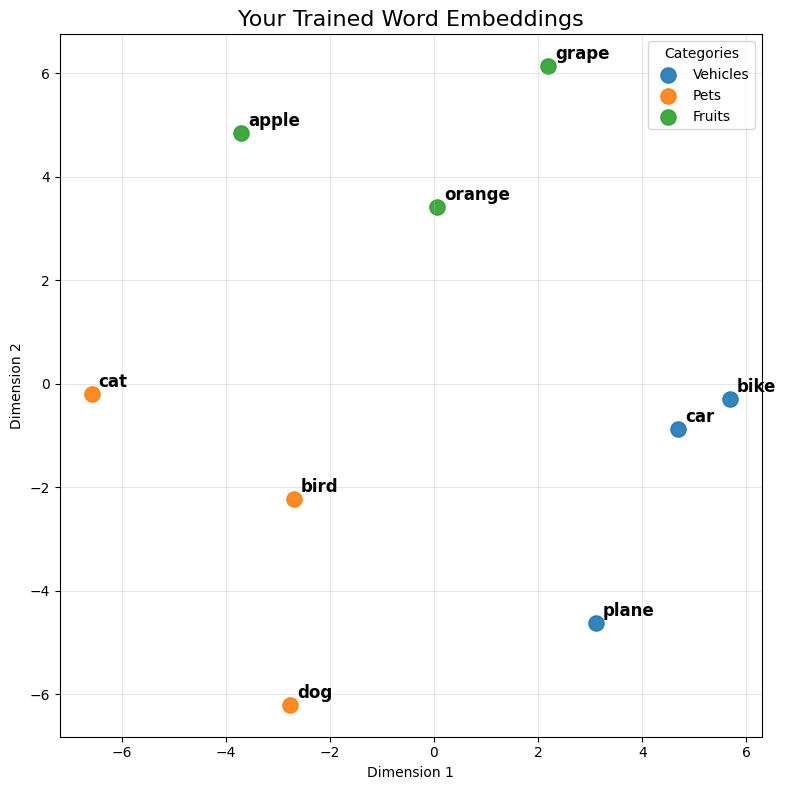

In [33]:
helper_utils.plot_embeddings(coords=coords, 
                             labels=vocabulary,
                             label_dict=vocab_categories,
                             title='Your Trained Word Embeddings'
                            )

The plot confirms that the training was a success. The result is conceptually similar to the GloVe plot you saw earlier. The words have once again separated into their three distinct semantic categories.

This powerfully demonstrates that even the simple model you built from scratch effectively learned the relationships between words, proving the core principle behind word embeddings.

## Beyond Static Embeddings: The Importance of Context

While training your own embeddings is a fantastic way to understand how they work, for many real-world applications, you don't need to start from scratch. As you saw in the first half of this notebook, pre-trained models offer a powerful and efficient starting point.

**Static models** like **GloVe** are excellent, computationally lightweight tools that are perfect for a variety of tasks where the broader meaning of words is sufficient. They are a great choice for applications like:

* General sentiment analysis
* Document classification or topic modeling
* Scenarios where speed and a smaller memory footprint are important

### The Limitation: The "Bat" Problem

However, the "one word, one vector" approach of static models has a key limitation when dealing with words that have multiple meanings (a concept known as **polysemy**).

For example, consider the word "bat" in these two sentences:

> 1. "A bat flew out of the cave." (an animal)
>
> 2. "He swung the baseball bat." (sports equipment)

A static model like GloVe will produce the exact same vector for "bat" in both cases. This vector is an average of all the contexts the model saw during its training, so it can't distinguish between the animal and the sports equipment.

Let's see this in action.

* First, define the two sentences you'll use for comparison.

In [34]:
# The sentences for comparison
sentence1 = "A bat flew out of the cave."
sentence2 = "He swung the baseball bat."

* Next, retrieve the specific pre-trained GloVe vector for the word `"bat"`.

In [35]:
# Get the specific vectors for "bat" from each sentence
bat_from_sentence1 = glove_embeddings["bat"]
bat_from_sentence2 = glove_embeddings["bat"]

* Print the vectors for both of the sentences.

In [36]:
# --- Print vectors for the first sentence ---
print("--- Sentence 1 (first 5 values) ---")
for word in sentence1.split():
    # Clean the word to remove common punctuation
    clean_word = word.strip('.,?!').lower()
    
    # Check if the clean word exists in the GloVe vocabulary
    if clean_word in glove_embeddings:
        vector = glove_embeddings[clean_word]
        print(f"{clean_word:<12} {vector[:5]}")
    else:
        print(f"{clean_word:<12} {'(not in vocabulary)'}")

--- Sentence 1 (first 5 values) ---
a            [-0.27086   0.044006 -0.02026  -0.17395   0.6444  ]
bat          [-0.47601  0.81705  0.11151 -0.22687 -0.80672]
flew         [-0.61176 -0.56443  0.191    0.26094  0.23175]
out          [-0.18572  0.30092  0.36868 -0.92801  0.12335]
of           [-0.1529  -0.24279  0.89837  0.16996  0.53516]
the          [-0.038194 -0.24487   0.72812  -0.39961   0.083172]
cave         [-0.20216   0.6304    0.078733  0.27121   0.088427]


In [37]:
# --- Print vectors for the second sentence ---
print("--- Sentence 2 (first 5 values) ---")
for word in sentence2.split():
    # Clean the word to remove common punctuation
    clean_word = word.strip('.,?!').lower()
    
    # Check if the clean word exists in the GloVe vocabulary
    if clean_word in glove_embeddings:
        vector = glove_embeddings[clean_word]
        print(f"{clean_word:<12} {vector[:5]}")
    else:
        print(f"{clean_word:<12} {'(not in vocabulary)'}")

--- Sentence 2 (first 5 values) ---
he           [ 0.1225   -0.058833  0.23658  -0.28877  -0.028181]
swung        [ 0.57178   0.20102   0.15684  -0.022487  0.13819 ]
the          [-0.038194 -0.24487   0.72812  -0.39961   0.083172]
baseball     [ 0.80381  0.46716  0.5546  -0.50325 -0.90828]
bat          [-0.47601  0.81705  0.11151 -0.22687 -0.80672]


* As a final confirmation, compare the two vectors retrieved for the word "bat" to prove they are identical.

In [38]:
# Check if the two vectors for "bat" are identical
are_identical = np.array_equal(bat_from_sentence1, bat_from_sentence2)
print(f"Are the vectors for 'bat' from each sentence identical? {are_identical}")

Are the vectors for 'bat' from each sentence identical? True


### The Solution: Contextual Embeddings with BERT

This is where advanced models like [BERT](https://huggingface.co/docs/transformers/en/model_doc/bert) (Bidirectional Encoder Representations from Transformers) come in. Unlike static models, BERT is **contextual**.

This means it generates a unique, dynamic vector for a word every time it appears, based on the specific sentence it's in.

Let's see this in action.

* Ensure the model is downloaded locally.

In [39]:
helper_utils.download_bert()

BERT model already found in './bert_model'. Skipping download.


* Load the tokenizer and the model into their respective variables.

In [40]:
# Define the local path where the BERT model is saved.
bert_path = './bert_model'

# Load the tokenizer and model from the specified path.
tokenizer, model_bert = helper_utils.load_bert(bert_path)

Loading BERT model from './bert_model'...
Model loaded successfully.


Print the contextual vector for each token in the sentences.

* First, process the first sentence. Uses the BERT tokenizer to prepare the input and then feed it into the model.
* Next, extract the `last_hidden_state`, which contains the final, context-aware embedding for every token in the sentence.
* Finally, loop through each token and its corresponding vector to print them side-by-side.

**Note**: The period (`.`) appears as a separate **token** because BERT's advanced tokenizer recognizes that punctuation has grammatical meaning; unlike the simple `.split()` method used in the GloVe example which required you to manually remove the period, the BERT tokenizer intentionally preserves it as a meaningful part of the sentence structure.

In [41]:
# --- Process and Print Vectors for Sentence 1 ---
print("--- Sentence 1 (first 5 values) ---")
# Tokenize the sentence and get the model's output
inputs1 = tokenizer(sentence1, return_tensors='pt')
with torch.no_grad():
    outputs1 = model_bert(**inputs1)
last_hidden_state1 = outputs1.last_hidden_state[0] # Embeddings for all tokens

# Get the actual tokens from their IDs
tokens1 = tokenizer.convert_ids_to_tokens(inputs1['input_ids'][0])

# Loop through each token and its corresponding vector
for token, vector in zip(tokens1, last_hidden_state1):
    # Print the token and the first 5 dimensions of its contextual vector
    print(f"{token:<12} {vector.numpy()[:5]}")

--- Sentence 1 (first 5 values) ---
[CLS]        [ 0.13996893  0.3872445  -0.29815295  0.08580273 -0.52378356]
a            [-0.02313893  0.41630274 -1.2191126   0.195493    0.27390313]
bat          [ 0.8754448   0.11576382 -0.2277104  -0.4097415  -0.02397753]
flew         [ 0.3101847   0.15165545 -0.7919442  -0.50885475 -0.0014438 ]
out          [-0.35072136 -0.05830457 -0.84991527 -0.76473016  0.14247626]
of           [-0.55596566  0.06647174 -1.114085   -0.82740766  0.8002788 ]
the          [ 0.09945644 -0.165891   -1.2638958  -0.17282562  0.6221497 ]
cave         [ 1.1348542   0.30221936 -0.7433192  -0.12465306  0.49787292]
.            [ 0.45406508  0.37016508 -0.34402934  0.01525516 -0.44614157]
[SEP]        [0.13755237 0.3306318  0.01278938 0.12486919 0.00732888]


* Now do the same with the second sentence.

In [42]:
# --- Process and Print Vectors for Sentence 2 ---
print("--- Sentence 2 (first 5 values) ---")
# Tokenize the sentence and get the model's output
inputs2 = tokenizer(sentence2, return_tensors='pt')
with torch.no_grad():
    outputs2 = model_bert(**inputs2)
last_hidden_state2 = outputs2.last_hidden_state[0] # Embeddings for all tokens

# Get the actual tokens from their IDs
tokens2 = tokenizer.convert_ids_to_tokens(inputs2['input_ids'][0])

# Loop through each token and its corresponding vector
for token, vector in zip(tokens2, last_hidden_state2):
    # Print the token and the first 5 dimensions of its contextual vector
    print(f"{token:<12} {vector.numpy()[:5]}")

--- Sentence 2 (first 5 values) ---
[CLS]        [-0.08804557  0.33414572 -0.10775331  0.15939695 -0.30334845]
he           [ 0.20504497  0.31979802 -0.31739578  0.5313574   0.36677855]
swung        [ 1.1175896   0.45602995 -0.5353461  -0.72856283 -0.59744   ]
the          [ 0.44677094  0.52125174 -0.93857586 -0.40604064 -0.01535924]
baseball     [ 0.8494498   0.42763188 -0.8115146  -0.46242163 -0.3579476 ]
bat          [ 1.4158053   0.61405706 -0.03513778 -1.2290715  -0.6463634 ]
.            [ 0.58587134  0.3880923  -0.40420413  0.25716662 -0.03693662]
[SEP]        [ 0.07653546  0.5526121  -0.04577377 -0.01444972  0.44209293]


* You can also perform the same identity check on the BERT vectors.
    * The result will be `False`, confirming that BERT produced two unique vectors for the word `"bat"`.

In [43]:
# Extract the vector for "bat" from the first sentence (at token index 2)
bat_animal_vector = last_hidden_state1[2].numpy()
# Extract the vector for "bat" from the second sentence (at token index 5)
bat_sport_vector = last_hidden_state2[5].numpy()
# Check if the two contextual vectors for "bat" are identical
are_identical = np.array_equal(bat_animal_vector, bat_sport_vector)
print(f"Are the contextual BERT vectors for 'bat' identical? {are_identical}")

Are the contextual BERT vectors for 'bat' identical? False


## The Takeaway: Which Model Should You Use?

After seeing the difference, the natural question is which type of embedding to use. The answer depends entirely on your specific task and resources.

**Use Static Embeddings (like GloVe) when:**

* You're performing a straightforward task like document classification where nuanced context is less critical.
* You need a fast, computationally lightweight solution with a smaller memory footprint.

**Use Contextual Embeddings (like BERT) when:**

* Your task requires a deep understanding of language and ambiguity (e.g., question-answering, text summarization, or advanced chatbots).
* Handling words with multiple meanings is important for your application's success.
* You have the computational resources to run larger, more complex models.

## Conclusion
In this lab, you have journeyed through the complete process of working with word embeddings, moving from abstract numbers to rich, meaningful vector representations. You began by loading a powerful pre-trained static model, GloVe, and saw firsthand how its vectors capture complex semantic relationships, allowing you to solve analogies with simple arithmetic. Visualizing these embeddings with PCA made it clear how words with similar meanings group together in vector space.

You then built your own embedding model from the ground up, gaining a fundamental understanding of how these representations are learned during training. This highlighted a pivotal limitation of static models: their inability to handle words with multiple meanings. To solve this, you explored BERT, a contextual model that generates unique embeddings based on a word's surrounding text, providing a far more nuanced understanding of language.

You now have the practical skills to load, train, visualize, and differentiate between static and contextual embeddings. This knowledge is an essential foundation for building more advanced neural networks that can perform sophisticated NLP tasks like text classification and sentiment analysis.